In [1]:
import numpy as np
import pandas as pd
import gc
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
import zipfile
# Define paths for the uploaded zip and csv files
images_zip_path = '/content/images.zip'
samples_zip_path = '/content/samples.zip'
label_csv_path = '/content/label.csv'

# Extract images.zip
with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')
print("Images extracted successfully!")

# Extract samples.zip
with zipfile.ZipFile(samples_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/samples')
print("Samples extracted successfully!")

Images extracted successfully!
Samples extracted successfully!


In [3]:
# Define correct paths after extraction
image_dir = '/content/images/'  # Corrected extracted path
samples_dir = '/content/samples/'  # Corrected extracted path
labels_dir = label_csv_path  # Correct path to label.csv

# Filter out '__MACOSX' directories if they exist
if '__MACOSX' in os.listdir('/content/'):
    os.system('rm -rf /content/__MACOSX')

# List and filter image and sample directories
image_dir = os.path.join('/content/images/', 'images')
samples_dir = os.path.join('/content/samples/', 'samples')

# Check extracted files and ignore '__MACOSX'
image_files = [f for f in os.listdir(image_dir) if not f.startswith('__')]
sample_files = [f for f in os.listdir(samples_dir) if not f.startswith('__')]

print("Image Directory:", image_files[:5])
print("Samples Directory:", sample_files[:5])
print("Label File:", labels_dir)

# Load label.csv
labels = pd.read_csv(labels_dir)
print(labels.head())

Image Directory: ['25063.jpg', '42128.jpg', '1595.jpg', '47818.jpg', '30776.jpg']
Samples Directory: ['4.jpg', '3.jpg', '6.jpg', '5.jpg', '1.jpg']
Label File: /content/label.csv
   hour  minute
0     4       2
1     9      44
2     3       6
3     3      30
4     2       3


In [4]:
# Check for missing values
print(labels.isnull().sum())

hour      0
minute    0
dtype: int64


In [5]:
# Convert labels to required format
labels['tuples'] = [('h' + str(x), 'm' + str(y)) for x, y in labels.values]
labels = labels.drop(columns=['hour', 'minute'])

# Transform labels to multi-label binary format
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(labels['tuples'])

In [6]:
train, test = train_test_split(labels,
                               stratify=labels['tuples'],
                               test_size=0.20,
                               random_state=42)

# Get train and test indices
train_idx, test_idx = list(train.index), list(test.index)

print(f"Training samples: {len(train_idx)}, Test samples: {len(test_idx)}")

Training samples: 40000, Test samples: 10000


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

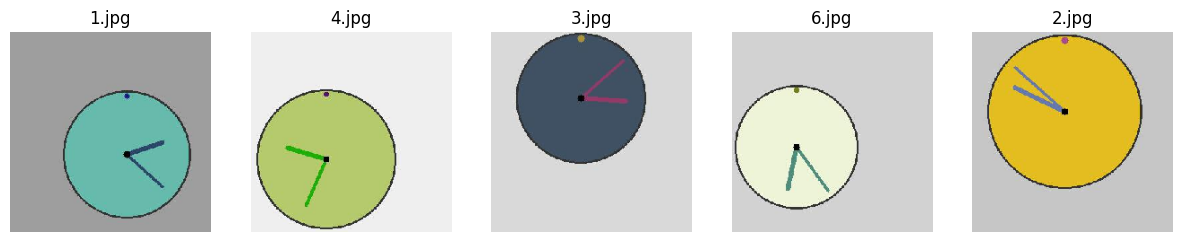

In [7]:
# Display random sample images from samples_dir
sample_images = random.sample(os.listdir(samples_dir), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(samples_dir, img_name)
    img = image.load_img(img_path, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(img_name)

plt.tight_layout

In [9]:
#preview of dataframe
labels.head()

,tuples
0,"(h4, m2)"
1,"(h9, m44)"
2,"(h3, m6)"
3,"(h3, m30)"
4,"(h2, m3)"


In [10]:
#distribution of unique labels
labels['tuples'].value_counts()

,count
tuples,
"(h4, m4)",94
"(h7, m22)",94
"(h10, m48)",93
"(h6, m32)",92
"(h1, m24)",92
...,...
"(h6, m27)",48
"(h9, m48)",47
"(h9, m7)",47


In [13]:
#creating train-test split
train, test = train_test_split(labels,
                               stratify=labels['tuples'],
                               test_size=0.20,
                               random_state=42
                              )

train_idx, test_idx = list(train.index), list(test.index)

In [14]:
def generate(image_directory, labels, train_idx=None, batch_size=64, size=(224, 224)):


    prebuilt_model = xception.Xception(include_top=True, weights='imagenet')
    xception_model = Model(inputs=prebuilt_model.input, outputs=prebuilt_model.layers[-2].output)

    while 1:

        if train_idx==None:
            image_filenames = os.listdir(image_directory)
        else:
            image_filenames = [str(idx) + '.jpg' for idx in train_idx]

        random.shuffle(image_filenames)                                      #shuffling the list to add randomness every epoch

        image_batch = []                                                     #initializing empty image batch list
        labels_batch = []                                                    #initializing empty labels batch list

        for file in image_filenames:                                         #looping over all images in directory

            index = int(file.split('.')[0])                                  #extracting image number/index from filename

            img = image.load_img(os.path.join(image_directory, file),        #loading image
                                 target_size=size,
                                 interpolation='box')

            img_arr = image.img_to_array(img, dtype='float32')               #converting image to array

            label = labels[index]                                            #using image number/index to find correct label in dataframe

            image_batch.append(img_arr)                                      #appending the image to the batch
            labels_batch.append(label)                                       #appending the label to the batch


            if len(image_batch)==batch_size:                                 #check to see if batch has required size
                image_batch = np.array(image_batch)                          #converting image batch list to array
                image_batch = xception.preprocess_input(image_batch)         #using xception preprocessing on image batch array
                image_features = xception_model.predict(image_batch)         #using prebuilt xception model to extract features from batch
                image_batch = np.array(image_features)                       #converting features to array
                image_batch = image_batch.reshape(batch_size,                #reshaping feature array
                                                  image_features.shape[1])
                labels_batch = np.array(labels_batch)                        #converting labels batch list to array
                yield image_batch, labels_batch                              #yielding image and labels batch array
                image_batch = []                                             #reinitializing the image batch
                labels_batch = []                                            #reinitializing the label batch
                gc.collect()                                                 #collecting garbage to free memory

In [15]:
#Defining training parameters
BATCH_SIZE = 256
IMAGE_SIZE = (299, 299) #this is the size suggested for Xception model
EPOCHS = 10
STEPS = int(len(train_idx) / BATCH_SIZE)

In [16]:
#testing generator
sample_generator = next(generate(image_directory=image_dir,
                                 labels=y,
                                 train_idx=train_idx,
                                 batch_size=1,
                                 size=IMAGE_SIZE))

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [17]:
#output of generator
sample_generator

(array([[0.        , 0.00699963, 0.13603328, ..., 0.257838  , 0.26209325,
         0.20953724]], dtype=float32),
 array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]))

In [18]:
#extracting input and output dims from generator
INPUT_DIM = sample_generator[0][0].shape
OUTPUT_DIM = sample_generator[1].shape[1]

In [19]:
print(INPUT_DIM, OUTPUT_DIM)

(2048,) 72


In [20]:
def create_model(input_shape, output_shape):

    input_layer = Input(shape=input_shape)
    norm  = BatchNormalization()(input_layer)
    drop = Dropout(0.25)(norm)
    fc1 = Dense(256, activation='relu')(norm)
    fc2 = Dense(256, activation='relu')(fc1)
    output1 = Dense(output_shape, activation='sigmoid')(fc2)

    #contructing model from layers
    model = Model(inputs=input_layer,
                  outputs=output1)

    #compiling model
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [21]:
#instance of model
model = create_model(input_shape=INPUT_DIM, output_shape=OUTPUT_DIM)

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 72)                  │          18,504 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 617,032 (2.35 MB)

 Trainable params: 612,936 (2.34 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [23]:
#initializing generator for training
generator = generate(image_directory=image_dir,
                     labels=y,
                     train_idx=train_idx,
                     batch_size=BATCH_SIZE,
                     size=IMAGE_SIZE)

In [24]:
#fitting model
history = model.fit(generator,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step
8/8 ━━━━━━━━━

In [31]:
def predict(image_directory, indices=None, plot=False):
    images_list = []

    # Load pre-trained Xception model and extract features
    prebuilt_model = xception.Xception(include_top=True, weights='imagenet')
    xception_model = Model(inputs=prebuilt_model.input, outputs=prebuilt_model.layers[-2].output)

    # Corrected condition to load appropriate image filenames
    if indices is not None:
        image_filenames = [str(idx) + '.jpg' for idx in indices]
    else:
        image_filenames = os.listdir(image_directory)

    # Handle case where no images are found
    if len(image_filenames) == 0:
        print("No images found in the directory.")
        return []

    # Plot settings if required
    if plot:
        dim = int(np.ceil(np.sqrt(len(image_filenames))))  # Create grid size
        fig, axs = plt.subplots(nrows=dim,
                                ncols=dim,
                                figsize=(20, 14))
        plt.suptitle('Example of Model Predictions', fontsize=32)

    # Loop through all images
    for i, file in enumerate(image_filenames):
        img_path = os.path.join(image_directory, file)

        # Skip missing or invalid files
        if not os.path.exists(img_path):
            print(f"Warning: File {img_path} not found. Skipping...")
            continue

        # Load and convert the image to array
        img = image.load_img(img_path, target_size=(299, 299))
        img_arr = image.img_to_array(img, dtype='float32')

        # Plot if enabled
        if plot:
            axs.flat[i].imshow(img_arr / 255.0)

        images_list.append(img_arr)
        gc.collect()

    # Handle case where no valid images are loaded
    if len(images_list) == 0:
        print("No valid images found after filtering.")
        return []

    print('Preprocessing...')
    images_list = np.array(images_list)
    img_arr = xception.preprocess_input(images_list)

    print('Extracting features...')
    img_features = xception_model.predict(img_arr)
    img_features = np.array(img_features)

    print('Predicting...')
    # Predict using the trained model
    prediction = model.predict(img_features)

    # Get hour and minute with highest probability
    hour_max = np.argmax(prediction[:, :12], axis=1)
    minute_max = np.argmax(prediction[:, 12:], axis=1) + 12

    # Map predictions back to binarizer classes
    prediction_list = [(binarizer.classes_[x], binarizer.classes_[y]) for (x, y) in list(zip(hour_max, minute_max))]

    # Plot predictions if enabled
    if plot:
        for i, v in enumerate(prediction_list):
            axs.flat[i].set_title(str(v[0]) + ' ' + str(v[1]))
            axs.flat[i].axis('off')

        # Remove extra subplots
        for j in range(i + 1, dim**2):
            fig.delaxes(axs.flat[j])

        plt.show()  # Show the plot

    return prediction_list

Preprocessing...
Extracting features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


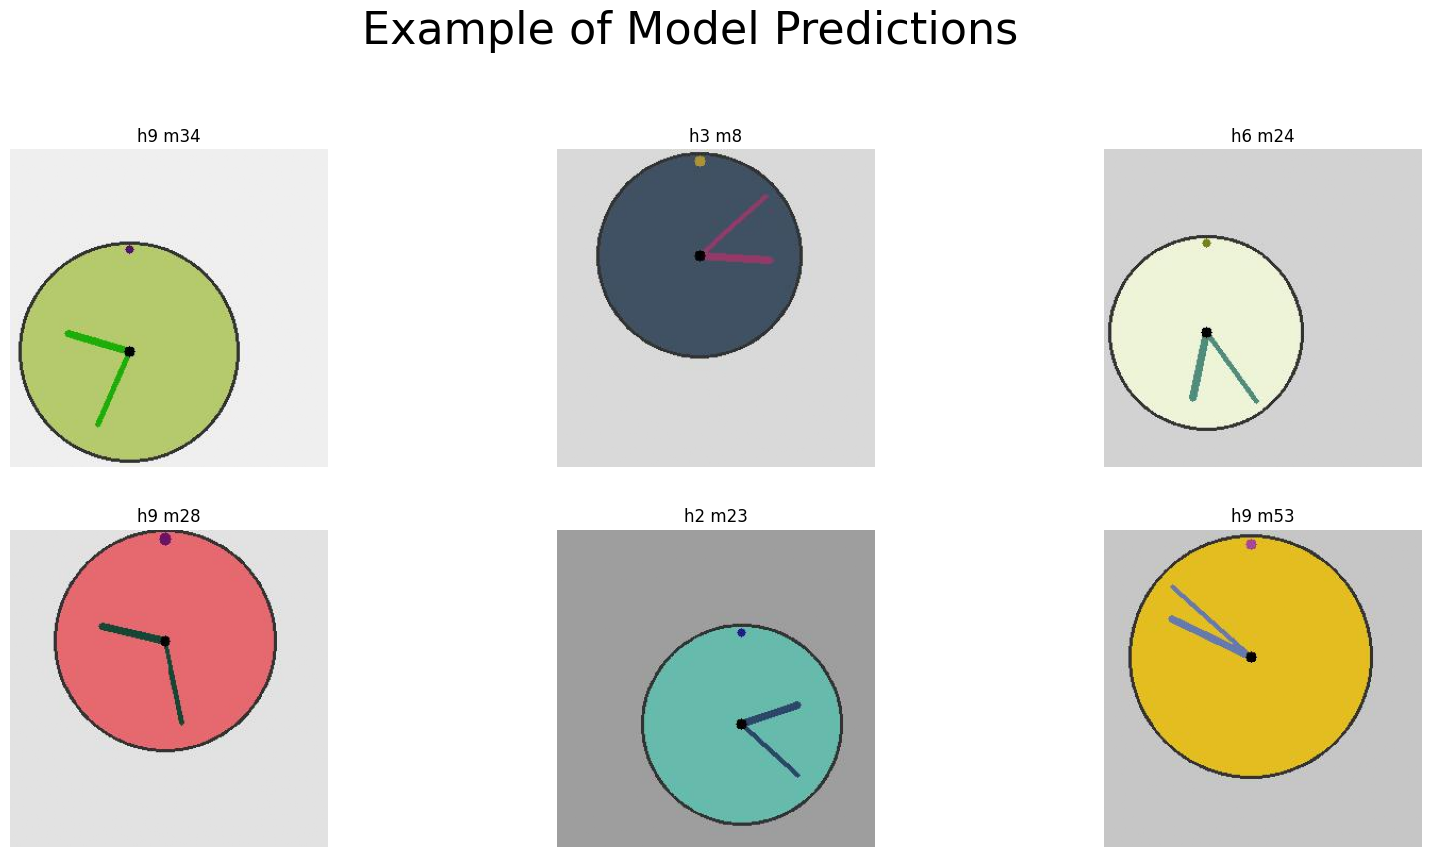

[('h9', 'm34'), ('h3', 'm8'), ('h6', 'm24'), ('h9', 'm28'), ('h2', 'm23'), ('h9', 'm53')]


In [32]:
# Predicting samples used in earlier visualization
predictions = predict(samples_dir, plot=True)

# Print predictions
print(predictions)

In [34]:
# Test data generator
test_generator = generate(image_directory=image_dir,
                          labels=y,
                          train_idx=test_idx,
                          batch_size=BATCH_SIZE,
                          size=IMAGE_SIZE)

# Number of test steps
TEST_STEPS = int(len(test_idx) / BATCH_SIZE)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator, steps=TEST_STEPS)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

In [35]:
# Save the trained model to a file
model.save('/content/analog_clock_model.h5')
print("Model saved successfully as 'analog_clock_model.h5'!")

Model saved successfully as 'analog_clock_model.h5'!


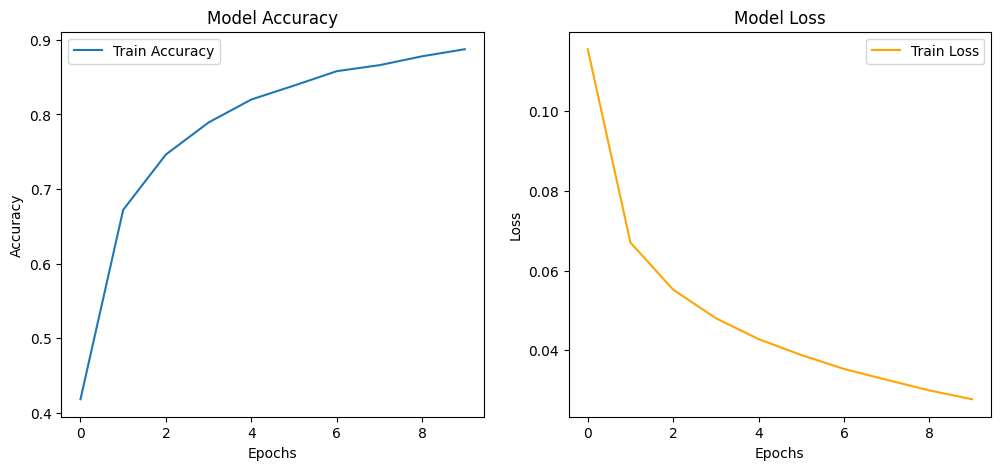

In [36]:
# Plot training accuracy and loss
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot loss
    axs[1].plot(history.history['loss'], label='Train Loss', color='orange')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

# Plot training history
plot_training_history(history)

In [38]:
# Print the training accuracy and loss for each epoch
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  - Training Accuracy: {history.history['accuracy'][epoch]}")
    print(f"  - Training Loss: {history.history['loss'][epoch]}")

Epoch 1/10
  - Training Accuracy: 0.4180939495563507
  - Training Loss: 0.11555029451847076
Epoch 2/10
  - Training Accuracy: 0.6721253991127014
  - Training Loss: 0.06703628599643707
Epoch 3/10
  - Training Accuracy: 0.7463441491127014
  - Training Loss: 0.05522078648209572
Epoch 4/10
  - Training Accuracy: 0.7892878651618958
  - Training Loss: 0.048065803945064545
Epoch 5/10
  - Training Accuracy: 0.8200621008872986
  - Training Loss: 0.04281315580010414
Epoch 6/10
  - Training Accuracy: 0.8387670516967773
  - Training Loss: 0.03881958872079849
Epoch 7/10
  - Training Accuracy: 0.8580729365348816
  - Training Loss: 0.035333771258592606
Epoch 8/10
  - Training Accuracy: 0.866135835647583
  - Training Loss: 0.032605838030576706
Epoch 9/10
  - Training Accuracy: 0.8780549168586731
  - Training Loss: 0.02994336560368538
Epoch 10/10
  - Training Accuracy: 0.8875450491905212
  - Training Loss: 0.02773110754787922


In [39]:
# Calculate the average training accuracy and loss
average_accuracy = np.mean(history.history['accuracy'])
average_loss = np.mean(history.history['loss'])

# Print the average accuracy and loss
print(f"Average Training Accuracy: {average_accuracy}")
print(f"Average Training Loss: {average_loss}")

Average Training Accuracy: 0.7774489253759385
Average Training Loss: 0.049311999790370466
